# Deep Learning - Data Exploration

### *Facial age prediction - a SML Regression problem*

# 1. References

1. WHO Age Group Codelist, [official documentation](https://apps.who.int/gho/data/node.searo-metadata.AGEGROUP?lang=en)
3. Life Expectancy of the World Population, [link](https://www.worldometers.info/demographics/life-expectancy/)
4. Testing different image hash functions, [blog article](https://content-blockchain.org/research/testing-different-image-hash-functions/)
5. How to use identify visually similar images using hashing, [blog article](https://practicaldatascience.co.uk/data-science/how-to-use-image-hashing-to-identify-visually-similar-or-duplicate-images)
6. imagehash Github repository, Johannes Buchner, [blog article](https://github.com/JohannesBuchner/imagehash)


# 2. Introduction

***Facial age recognition - a SML regression problem*** 
 
Our project focuses on a supervised machine learning regression problem. The goal of the project is to predict the age of a person based on a face image. We are using the [*facial age*](https://www.kaggle.com/datasets/frabbisw/facial-age) dataset from Kaggle, which consists of 99 folders. Each folder represents the age of the faces contained within it and was generated from WIKI_ART.

# 3. Initial Treatment

## 3.1. Configurations and import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install imageio --quiet
!pip install kaggle --quiet
!pip install imagehash --quiet

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics
import imageio.v2 as imageio
from google.colab import files

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

import os
import time
import shutil
import random 
import zipfile
import math
from collections import defaultdict
import imagehash
import itertools
import pickle
import seaborn as sns

import gdown # To download zip file from URL
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import seaborn as sns

import numpy as np
import pandas as pd

## 3.2. Auxiliary functions

Collection of all user defined functions in this notebook. 

In [ ]:
def load_images(root_folder):
  """
  Load images from a given root folder and create a dataframe containing 
  metadata (height, width, channels etc.) and pixel structure.
  
  Args: 
  --
    root_folder (str): The root folder containing the images.
      
  Returns:
  --
    images_df (pd.DataFrame): A dataframe containing with pixel structure and metadata
  """
  # Initialize timer
  t0 = time.time()
  # Initialize lists to store metadata and pixel data
  images_data = []

  # Iterate through the directory structure
  for dirpath, dirnames, filenames in os.walk(root_folder):
      folder_name = os.path.basename(dirpath)
      print(folder_name, end=' ')
      # Iterate through the files in the current folder
      for filename in filenames:
          file_extension = os.path.splitext(filename)[1].lower()
          # Check if the file is an image
          if file_extension in ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']:
              image_path = os.path.join(dirpath, filename)

              try:
                  # Get image size and channels
                  img = imageio.imread(image_path)
                  height, width = img.shape[:2]
                  channels = img.shape[2] if len(img.shape) > 2 else 1

                  # Calculate aspect ratio
                  aspect_ratio = width / height

                  # Append metadata and pixel data to the images_data list
                  images_data.append({
                      'age_label': int(folder_name),
                      'file_name': filename,
                      'file_extension': file_extension,
                      'height': height,
                      'width': width,
                      'aspect_ratio': aspect_ratio,
                      'channels': channels,
                      'pixels': img,
                      'size_image': (str(height)
                                      + ', ' 
                                      + str(width)
                                      + ', '
                                      + str(channels))
                  })

              except Exception as e:
                  print(f"Error opening image {image_path}: {e}")
  # Convert the list of dictionaries to a dataframe
  images_df = pd.DataFrame(images_data)
  print("\nLoaded images in %0.3f seconds" % (time.time() - t0))
  return images_df

In [ ]:
def is_grayscale(image_path):
  '''
  Check if an image is grayscale or not.

  Args:
  --
    image_path (str): The file path of the image to be checked.

  Returns:
  --
    bool: True if the image is grayscale, False otherwise.
  '''
  img = Image.open(image_path).convert('RGB')
  width, height = img.size
  for w in range(width):
      for h in range(height):
          r, g, b = img.getpixel((w,h))
          if r != g != b: 
              return False
  return True

In [ ]:
def create_image_grid(image_paths, images_per_row):
  '''
  Creates a grid of images from a list of image paths.

  Args:
  --
    image_paths (list): A list of paths to the images to include in the grid.
    images_per_row (int): The number of images to display in each row of the grid.

  Returns:
  --
    None. Resulting image grid is saved to a file and displayed on screen.
  '''
  
  image_files = [f for f in image_paths if os.path.splitext(f)[1].lower() in ('.png', '.jpg', '.jpeg')]

  img_sizes = [Image.open(f).size for f in image_files]
  max_width = max([size[0] for size in img_sizes])
  max_height = max([size[1] for size in img_sizes])

  num_rows = math.ceil(len(image_files) / images_per_row)
  grid_size = (max_width * images_per_row, max_height * num_rows)
  grid_image = Image.new('RGB', grid_size, color='white')

  for i, image_file in enumerate(image_files):
      img = Image.open(image_file)

      x = (i % images_per_row) * max_width
      y = (i // images_per_row) * max_height
      grid_image.paste(img, (x, y))

  grid_image.save('image_grid.jpg')
  grid_image.show()

In [ ]:
def create_image_grid_per_group(image_groups, images_per_row, show_class=False):
  '''
  Creates a grid of images for each group of images in a dictionary.

  Args:
  --
    image_groups (dict): A dictionary where the keys are group labels and the values are lists of paths to the images in each group.
    images_per_row (int): The number of images to display in each row of the grid.
    show_class (bool): Parameter to show or not the class of the image

  Returns:
  --
    None. The resulting image grids are saved to .jpg files and displayed on screen.
  '''

  for group_label, image_paths in image_groups.items():
    print("--------------------------------------------------------------------")
    print(group_label)
    if show_class:
        groups_list = [path.split('/')[-2] for path in image_paths] 
        print(groups_list)
    print("--------------------------------------------------------------------")
    image_files = [f for f in image_paths if os.path.splitext(f)[1].lower() in ('.png', '.jpg', '.jpeg')]

    img_sizes = [Image.open(f).size for f in image_files]
    max_width = max([size[0] for size in img_sizes])
    max_height = max([size[1] for size in img_sizes])

    num_rows = math.ceil(len(image_files) / images_per_row)
    grid_size = (max_width * images_per_row, max_height * num_rows)
    grid_image = Image.new('RGB', grid_size, color='white')

    for i, image_file in enumerate(image_files):
        img = Image.open(image_file)

        x = (i % images_per_row) * max_width
        y = (i // images_per_row) * max_height
        grid_image.paste(img, (x, y))

    grid_image.save(f'image_grid_{group_label}.jpg')
    grid_image.show()

In [ ]:
def true_duplicates(image_path1, image_path2):
  '''
  Determines if two images are identical.

  Args:
  --
    image_path1 (str): The path to the first image.
    image_path2 (str): The path to the second image.

  Returns:
  --
    bool: True if the images are identical, False otherwise.
  '''

  image1 = Image.open(image_path1)
  image2 = Image.open(image_path2)

  pixels1 = image1.load()
  pixels2 = image2.load()

  channels = len(image1.getbands())

  for x in range(image1.width):
    for y in range(image1.height):
      for z in range(channels):
        if pixels1[x, y][z] != pixels2[x, y][z]:
          return False

  return True

In [ ]:
def find_closest_individuals(distance_matrix, threshold):
  """
  Identify the closest individuals according to a distance threshold.

  Args:
  --
  distance_matrix (numpy.ndarray): A 2D array containing the pairwise distances between individuals.
  threshold (float): The distance threshold to consider individuals as close.

  Returns:
  --
  close_individuals (list): A list of tuples containing the indices of the closest individuals.
  """
  close_individuals = []

  # Iterate through the distance matrix
  for i in range(distance_matrix.shape[0]):
      for j in range(i + 1, distance_matrix.shape[1]):
          # Check if the distance is below the threshold
          if distance_matrix[i, j] <= threshold:
              close_individuals.append((i, j, distance_matrix[i,j]))

  return close_individuals

In [ ]:
def generate_hashes_for_images(root_folder, hash_option=imagehash.average_hash):
    """
    Generate hashes for images in a given folder and its subfolders using the specified hash option.

    This function walks through the root folder and its subfolders, generating hashes for all image files
    with the following extensions: .png, .jpg, .jpeg, .gif, and .bmp. The hash option can be set to any
    function from the imagehash library, with the default being imagehash.average_hash.

    Args:
    --
    root_folder (str): The path to the root folder containing the images.
    hash_option (function, optional): The hashing function from the imagehash library to use.
                                          Defaults to imagehash.average_hash.
    
    Returns:
    --
    dict: A dictionary containing the image file paths as keys and their corresponding hash values as strings.

    Raises:
    --
    Exception: If there is an error processing an image file, the function prints the error message and continues.
    """
    hashes = {}
    print(f'Generating Hash - Type of Hash: {hash_option}')
    print('Running in folder: ')
    for root, dirs, files in os.walk(root_folder):
        print(root.split('/')[-1], end=' ')
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                try:
                    image_path = os.path.join(root, file)
                    image = Image.open(image_path)
                    hash = hash_option(image)
                    hashes[image_path] = str(hash)
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")
    print('\n')
    return hashes

In [ ]:
def find_keys_with_same_values(dct):
    """
    Find keys in a dictionary that have the same values and create an inverse dictionary with the values as keys.

    This function iterates through the input dictionary, groups keys with the same values, and creates a new
    dictionary with the values as keys and lists of corresponding keys as values. Only values with more than one
    associated key are included in the inverted dictionary.

    Args:
    --
    dct (dict): The input dictionary with keys and values.

    Returns:
    --
    dict: An inverted dictionary with values as keys and lists of corresponding keys as values. Only values
              with more than one associated key are included.
    """
    value_to_keys = {}
    for key, value in dct.items():
        if value not in value_to_keys:
            value_to_keys[value] = []
        value_to_keys[value].append(key)

    inverted_dict = {}
    for value, keys in value_to_keys.items():
        if len(keys) > 1:
            inverted_dict[value] = keys

    return inverted_dict

## 3.3 Download and unzip dataset

In [ ]:
# Define the path, where the dataset should be saved
vm_path = "/content"
path = "/content/drive/MyDrive/FacialAgeProject/"

data_path = os.path.join(path, 'data')
metadata_path = os.path.join(path, 'metadata')
dataset_path = os.path.join(data_path, "facial_age_dataset_unsplit/")

**Download via Kaggle**

In [ ]:
# # Need to upload the kaggle.json file to user Kaggle API
# files.upload()  # Upload your kaggle.json file

In [ ]:
# # Set the correct permissions for the kaggle.json file
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# # Download the dataset using the Kaggle API
# !kaggle datasets download -d frabbisw/facial-age --force

In [ ]:
# # Unzip the dataset and save it to your Google Drive
# with zipfile.ZipFile('facial-age.zip', 'r') as zip_ref:
#     zip_ref.extractall(data_path)

## 3.4 Loading the images

To simplify the analysis of each image, we construct a dataframe that contains both metadata and pixel structure information for each image. 

The metadata includes:
- age group
- file name
- file extension
- image size (including number of channels)
- aspect ratio (calculated as the ratio of height to width)


In [ ]:
# Load all images from the folder and create the dataframe
images_df = load_images(dataset_path)

 001 002 003 004 005 006 007 008 009 010 011 012 013 014 015 016 017 018 019 020 021 022 023 024 025 026 027 028 029 030 031 032 033 034 035 036 037 038 039 040 041 042 043 044 045 046 047 048 049 050 051 052 053 054 055 056 057 058 059 060 061 062 063 064 065 066 067 068 069 070 071 072 073 074 075 076 077 078 079 080 081 082 083 084 085 086 087 088 089 090 091 092 093 095 096 099 100 101 110 
Loaded images in 59.098 seconds


In [ ]:
# Check if metadata was correctly saved
images_df.head()

,age_label,file_name,file_extension,height,width,aspect_ratio,channels,pixels,size_image
0,1,1000.png,.png,200,200,1.0,3,"[[[140, 93, 75], [152, 105, 87], [165, 116, 99...","200, 200, 3"
1,1,1018.png,.png,200,200,1.0,3,"[[[240, 239, 234], [238, 237, 232], [238, 235,...","200, 200, 3"
2,1,1030.png,.png,200,200,1.0,3,"[[[211, 211, 213], [208, 208, 210], [217, 217,...","200, 200, 3"
3,1,1062.png,.png,200,200,1.0,3,"[[[191, 132, 92], [192, 133, 93], [192, 133, 9...","200, 200, 3"
4,1,1068.png,.png,200,200,1.0,3,"[[[35, 31, 22], [30, 25, 19], [30, 22, 20], [3...","200, 200, 3"


In [ ]:
# Save a csv file with the metadata
save_path = os.path.join(metadata_path, "images_metadata.csv")
images_df.to_csv(save_path, index=False)

# 4. Data Exploration



## 4.1 Loading the CSV file

In [ ]:
# Loads the CSV file
images_df = pd.read_csv(os.path.join(metadata_path, "images_metadata.csv"))
images_df

,age_label,file_name,file_extension,height,width,aspect_ratio,channels,pixels,size_image
0,1,1000.png,.png,200,200,1.0,3,[[[140 93 75]\n [152 105 87]\n [165 116 ...,"200, 200, 3"
1,1,1018.png,.png,200,200,1.0,3,[[[240 239 234]\n [238 237 232]\n [238 235 2...,"200, 200, 3"
2,1,1030.png,.png,200,200,1.0,3,[[[211 211 213]\n [208 208 210]\n [217 217 2...,"200, 200, 3"
3,1,1062.png,.png,200,200,1.0,3,[[[191 132 92]\n [192 133 93]\n [192 133 ...,"200, 200, 3"
4,1,1068.png,.png,200,200,1.0,3,[[[ 35 31 22]\n [ 30 25 19]\n [ 30 22 ...,"200, 200, 3"
...,...,...,...,...,...,...,...,...,...
9773,100,2694.png,.png,200,200,1.0,3,[[[221 222 226]\n [232 235 240]\n [232 237 2...,"200, 200, 3"
9774,100,6408.png,.png,200,200,1.0,3,[[[51 41 32]\n [50 40 31]\n [48 38 29]\n .....,"200, 200, 3"
9775,101,1554.png,.png,200,200,1.0,3,[[[206 227 222]\n [206 227 222]\n [206 227 2...,"200, 200, 3"
9776,110,3906.png,.png,200,200,1.0,3,[[[6 0 0]\n [6 0 0]\n [4 0 0]\n ...\n [0 0...,"200, 200, 3"


## 4.2 Quantitative Analysis



### 4.2.1 General Overview

In the next step, we will check the metadata and pixel structure of the images stored in the previously created CSV file.  
This includes:
- the total number of images
- the number of images per age group
- the size and channel of the images
- types of files. 

Additionally, we check for duplicate images using the pixel information.

In [ ]:
print("Quantity Analysis of images")
print("------------------------------------")
print("Total images:", images_df.shape[0])
print("Types of file extension:", set(images_df['file_extension']))
print("Size of Images:", set(images_df['size_image']))
print("Duplicated records found:", len(images_df['pixels']) -   len(images_df['pixels'].drop_duplicates()))

Quantity Analysis of images
------------------------------------
Total images: 9778
Types of file extension: {'.png'}
Size of Images: {'200, 200, 3'}
Duplicated records found: 111


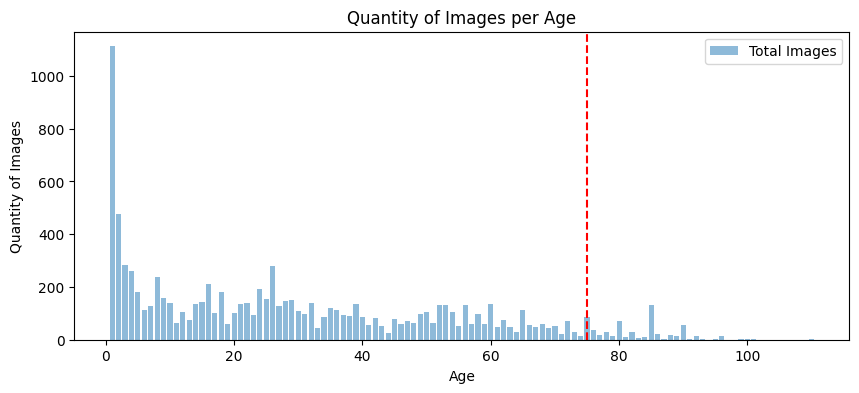

In [ ]:
grouped_counts = images_df.groupby('age_label').size().reset_index(name='count')

# Create a scatter plot
plt.figure(figsize=(10,4))
plt.bar(grouped_counts['age_label'], grouped_counts['count'], label='Total Images', alpha=0.5)

# Add labels and legend
plt.title('Quantity of Images per Age')
plt.xlabel('Age')
plt.ylabel('Quantity of Images')
plt.axvline(x=75, color="red", linestyle="--")
plt.legend()

# Show the plot
plt.show()

In [ ]:
gray_images = []

for split in os.listdir(dataset_path):
    for directory_name, subdirectories, files in os.walk(os.path.join(dataset_path, split)):
        for file in files:
            image_path = os.path.join(directory_name, file)
            if is_grayscale(image_path):
                gray_images.append(image_path)

print(f"Number of grayscale images in the dataset: {len(gray_images)}")

Number of grayscale images in the dataset: 106


**Summary**

- The complete dataset consists of 9778 PNG images.
- All of the images have the shape of (200, 200, 3), so there is no need for image resizing in the Data Pre-Processing step.
- 106 images are in grayscale.
- There are 111 images with identical pixel structures in the dataset. Further validation will be later done to verify and inspect the duplicates.
- The dataset is imbalanced with more images for younger age groups. The age groups with the least amount of images is 70+, which corresponds to the average life expectancy of the world population being around 73 years. We will deal with this problem during the pre-processing.



### 4.2.2 Visual Inspection of the images

To verify that images have coherence with the proposal of the dataset, we do a visual inspection of a sample of images overall and per age group.

**Visual inspection of images across all age groups**

In [ ]:
images_df['path'] = (images_df['age_label'].apply(lambda x: f"{x:03d}") + '/' + images_df['file_name'])
list_of_images = random.choices(list(images_df['path']), k=50)

In [ ]:
qty_images = 100

images_df['path'] = (images_df['age_label'].apply(lambda x: f"{x:03d}") + '/' + images_df['file_name'])
list_of_images = random.choices(list(images_df['path']), k=qty_images)

image_paths = [os.path.join(dataset_path, file_path) for file_path in list_of_images]

images_per_row = 5

create_image_grid(image_paths, images_per_row)

Output hidden; open in https://colab.research.google.com to view.

**Visual inspection of images per age group**

Before plotting the images, we create age groups, based on the information provided by the U.S. department of Health & Human Servies and the WHO. In total we create 7 age groups. [1][2]

In [ ]:
age_bins = [0, 5, 10, 17, 25, 40, 64, float('inf')]
age_labels = ['A_0-5', 'B_6-10', 'C_11-17', 'D_18-25', 'E_26-40', 'F_40-64', 'G_65+']
images_df['age_grouped_label'] = pd.cut(images_df['age_label'], bins=age_bins, labels=age_labels)

In [ ]:
path_dict = {}
qty_images_per_group = 16
images_per_row = 8

group_list = list(set(images_df['age_grouped_label']))
group_list.sort()

for age in group_list:
    path_dict[age] = random.choices(list(images_df[images_df['age_grouped_label']==age]['path']), k=qty_images_per_group)
    path_dict[age] = [os.path.join(dataset_path, file_path) for file_path in path_dict[age]]

create_image_grid_per_group(path_dict, images_per_row)

Output hidden; open in https://colab.research.google.com to view.

**Summary of Visual Inspection**  

- Upon inspection, it was found that the images in the dataset are all in portrait mode, depicting only the face and shoulders of the individuals.
- The sharpness of the images varies greatly, with some being clear and others appearing blurry
- Most of the images are frontal portraits where the subject is looking directly at the camera.
- Some images have watermarks and other artefacts.
- The dataset predominantly features individuals of White, Asian, and Indian descent. There is a notable underrepresentation of Black individuals in the dataset. To address this potential racial representation bias, it may be necessary to include more images of Black individuals in the dataset. As this point is significant, we will address it again in the conclusion of our Exploration notebook.


### 4.2.3 Duplicated images

By analysing the CSV file created from the metadata of all images, we identified that 111 images have the same pixel structure. For validation we will apply in the following three different techniques to verify the information:

1. Calculate the average hash value of each image, by using the `imagehash` library [4] [5] [6]
2. Calculate the perceptual hash value of each image, by using the `imagehash` library [4] [5] [6]
2. Calculate the pairwise distance between two images

The hope is that we can spot the same image that could have minors differences in the pixel structure. 

#### 4.2.3.1 **Average hash value of each image**

To create an ahash representation of an image, the algorithm performs the following steps:

1. The image is converted to grayscale.
2. The image is resized to a small, fixed size (e.g. 8x8 pixels).
3. The average brightness value of all pixels in the image is calculated.
4. Each pixel's brightness value is compared to the average value.
5. If the pixel's brightness value is greater than or equal to the average value, a corresponding bit in the hash value is set to 1. Otherwise, it is set to 0.

The resulting binary hash value represents the essential features of the image in a compact format. To compare two images using ahash, their hash values are calculated and the hamming distance between them is measured (i.e. the number of bit positions where the two hash values differ). If the hamming distance is below a certain threshold, the two images are considered similar. [4] [5] [6]

In [ ]:
# Generating ahahs for images
ahash = generate_hashes_for_images(root_folder=dataset_path, hash_option=imagehash.average_hash)

Generating Hash - Type of Hash: <function average_hash at 0x7f06c1051ee0>
Running in folder: 
 001 002 003 004 005 006 007 008 009 010 011 012 013 014 015 016 017 018 019 020 021 022 023 024 025 026 027 028 029 030 031 032 033 034 035 036 037 038 039 040 041 042 043 044 045 046 047 048 049 050 051 052 053 054 055 056 057 058 059 060 061 062 063 064 065 066 067 068 069 070 071 072 073 074 075 076 077 078 079 080 081 082 083 084 085 086 087 088 089 090 091 092 093 095 096 099 100 101 110 



In [ ]:
print('Quantity of duplicated images: ', len(ahash.values()) - len(set(ahash.values())))

Quantity of duplicated images:  249


In [ ]:
# Find the images that have the same hash
duplicated_keys = find_keys_with_same_values(ahash)
# Calculate the max size of possible duplicated images
images_per_row = max([len(count_keys) for count_keys in duplicated_keys.values()])

# Creating a visual inspection for the hashes
create_image_grid_per_group(image_groups=duplicated_keys, images_per_row=images_per_row, show_class=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
name_file = 'ahash_metadata.pkl'
# save dictionary to ahash_metadata.pkl file
with open(os.path.join(metadata_path, name_file), 'wb') as fp:
    pickle.dump(duplicated_keys, fp)
    print(f'Dictionary saved successfully into {os.path.join(metadata_path, name_file)}')

name_file = 'ahash_duplicated_keys.pkl'
# save dictionary to ahash_metadata.pkl file
with open(os.path.join(metadata_path, name_file), 'wb') as fp:
    pickle.dump(duplicated_keys, fp)
    print(f'Dictionary saved successfully into {os.path.join(metadata_path, name_file)}')

Dictionary saved successfully into /content/drive/MyDrive/FacialAgeProject/metadata/ahash_metadata.pkl
Dictionary saved successfully into /content/drive/MyDrive/FacialAgeProject/metadata/ahash_duplicated_keys.pkl


#### 4.2.3.2 **Perceptual hash value of each image**



The phash representation of an image is very similar to the ahash, but they differ on the following:

1. Algorithmic approach: Phash uses a Discrete Cosine Transform (DCT) to extract the frequency information from the image, while ahash uses a simple average brightness value comparison to create the hash.

2. Robustness to image transformations: Phash is more robust to image transformations, such as rotation, scaling, and translation, due to the use of the DCT. Ahash, on the other hand, is less robust to these transformations as it only compares the average brightness of the image.

3. Accuracy: While phash may be more accurate in some cases due to its ability to handle image transformations, ahash can be more accurate for detecting near-duplicates in image sets that have not undergone significant transformations. [4] [5] [6]

In [ ]:
phash = generate_hashes_for_images(root_folder=dataset_path, hash_option=imagehash.phash)

Generating Hash - Type of Hash: <function phash at 0x7f06c1051f70>
Running in folder: 
 001 002 003 004 005 006 007 008 009 010 011 012 013 014 015 016 017 018 019 020 021 022 023 024 025 026 027 028 029 030 031 032 033 034 035 036 037 038 039 040 041 042 043 044 045 046 047 048 049 050 051 052 053 054 055 056 057 058 059 060 061 062 063 064 065 066 067 068 069 070 071 072 073 074 075 076 077 078 079 080 081 082 083 084 085 086 087 088 089 090 091 092 093 095 096 099 100 101 110 



In [ ]:
print('Quantity of duplicated images: ', len(phash.values()) - len(set(phash.values())))

Quantity of duplicated images:  176


In [ ]:
# Find the images that have the same hash
duplicated_keys = find_keys_with_same_values(phash)
# Calculate the max size of possible duplicated images
images_per_row = max([len(count_keys) for count_keys in duplicated_keys.values()])

# Creating a visual inspection for the hashes
create_image_grid_per_group(image_groups=duplicated_keys, images_per_row=images_per_row, show_class=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
name_file = 'phash_metadata.pkl'
# save dictionary to phash_metadata.pkl file
with open(os.path.join(metadata_path, name_file), 'wb') as fp:
    pickle.dump(phash, fp)
    print(f'Dictionary saved successfully into {os.path.join(metadata_path, name_file)}')

name_file = 'phash_duplicated_keys.pkl'
# save dictionary to phash_duplicated_keys.pkl file
with open(os.path.join(metadata_path, name_file), 'wb') as fp:
    pickle.dump(duplicated_keys, fp)
    print(f'Dictionary saved successfully into {os.path.join(metadata_path, name_file)}')

Dictionary saved successfully into /content/drive/MyDrive/FacialAgeProject/metadata/phash_metadata.pkl
Dictionary saved successfully into /content/drive/MyDrive/FacialAgeProject/metadata/phash_duplicated_keys.pkl


#### 4.2.3.3 **Approach with Distance Matrix**

The idea is to create a distance matrix between all the images. This distance should considerate each pixel as a variable and, then, a euclidean distance could be used to compute the geometric distance betwen each instance (images). 

To do this we must : 


1.   Put all the images into a grey scale color mode (so we can only work with one channel and decrease the total computational effert needed)
2.   Flatten our dataset

Afterwards, we are conducting an experiment to assess the number of potentially duplicated images per distance. Our hypothesis is that in a certain distance threshold, the number of duplicated images will explode because it will be too large and identify different images.





In [ ]:
# Generate an object of type tf.data.Dataset 
image_size=(200, 200)
crop_to_aspect_ratio=True
color_mode='grayscale' # Reduce the number of channel so it doesn't get too overwhelming the calculations of distances
batch_size=64
label_mode="int"
seed=0

data_images = image_dataset_from_directory(dataset_path, 
                                          image_size=image_size,
                                          crop_to_aspect_ratio=crop_to_aspect_ratio,
                                          color_mode=color_mode,
                                          batch_size=batch_size,
                                          label_mode=label_mode,
                                          shuffle = False,
                                          seed=seed)
files_list = data_images.file_paths
# Check object properties
print("\nObject's type:\t", type(data_images))
print("Is it a tf.data.Dataset?\t R:",isinstance(data_images, tf.data.Dataset))
print("Classes:", data_images.class_names)

Found 9778 files belonging to 99 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '095', '096', '099', '100', '101', '110']


In [ ]:
# Scale and Flatenning
preprocess_layer = Sequential([# Input
                              layers.Input((200,200,1)),
                              # Rescaling
                              layers.Rescaling(1./255),
                              # Flatten
                              layers.Flatten()],name='preprocess')
X_flatten = preprocess_layer.predict(data_images)

# Calculate the pairwise distances
distance_matrix = pairwise_distances(X_flatten, metric='euclidean')

153/153 [==============================] - 51s 317ms/step


In [ ]:
# Testing the method with a distance of 5, as an example #

threshold = 5 # Minimum distance to be considered duplicate
closest_individuals_idx = find_closest_individuals(distance_matrix, threshold)
closest_individuals_files = [(files_list[idx1],files_list[idx2],distance) for idx1,idx2,distance in closest_individuals_idx]
print('Number of duplicated images (threshold :{}) : {}'.format(threshold,len(closest_individuals_files)))
print(closest_individuals_files)

Number of duplicated images (threshold :5) : 206
[('/content/drive/MyDrive/FacialAgeProject/data/facial_age_dataset_unsplit/001/1423.png', '/content/drive/MyDrive/FacialAgeProject/data/facial_age_dataset_unsplit/001/3968.png', 4.9943976), ('/content/drive/MyDrive/FacialAgeProject/data/facial_age_dataset_unsplit/001/146.png', '/content/drive/MyDrive/FacialAgeProject/data/facial_age_dataset_unsplit/001/9081.png', 4.795e-05), ('/content/drive/MyDrive/FacialAgeProject/data/facial_age_dataset_unsplit/001/1523.png', '/content/drive/MyDrive/FacialAgeProject/data/facial_age_dataset_unsplit/002/2336.png', 2.789209), ('/content/drive/MyDrive/FacialAgeProject/data/facial_age_dataset_unsplit/001/1639.png', '/content/drive/MyDrive/FacialAgeProject/data/facial_age_dataset_unsplit/004/7023.png', 4.501858), ('/content/drive/MyDrive/FacialAgeProject/data/facial_age_dataset_unsplit/001/1972.png', '/content/drive/MyDrive/FacialAgeProject/data/facial_age_dataset_unsplit/001/6911.png', 4.927621), ('/conten

In [ ]:
# Print founded duplicated images
for path1,path2, distance in closest_individuals_files :
  f,ax = plt.subplots(1, 2)
  image1,image2 = mpimg.imread(path1),mpimg.imread(path2)
  ax[0].imshow(image1)
  ax[0].set_title('{} - Distance = {}'.format(path1.split('/')[-1],distance))
  ax[1].imshow(image2)
  ax[1].set_title('{}'.format(path2.split('/')[-1]))
  plt.axis('off')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Experiment to assess number of pairs of images detected per distance threshold
threshold_max = 30
experiment_result = {}
files_per_threshold = {}
for thresh in range(0,threshold_max,5) :
  closest_individuals_idx = find_closest_individuals(distance_matrix, thresh)
  closest_individuals_files = [(files_list[idx1],files_list[idx2],distance) for idx1,idx2,distance in closest_individuals_idx]
  experiment_result[thresh] = len(closest_individuals_files)
  files_per_threshold[thresh] = closest_individuals_files
  print(experiment_result)

{0: 6}
{0: 6, 5: 206}
{0: 6, 5: 206, 10: 298}
{0: 6, 5: 206, 10: 298, 15: 335}
{0: 6, 5: 206, 10: 298, 15: 335, 20: 1091}
{0: 6, 5: 206, 10: 298, 15: 335, 20: 1091, 25: 22843}


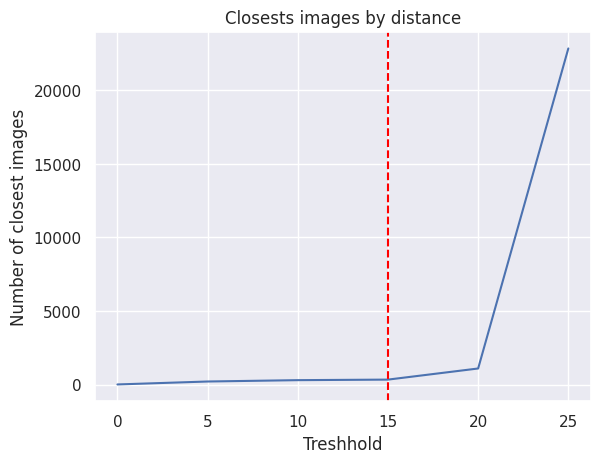

In [ ]:
sns.set_theme(style="darkgrid")

sns.lineplot(x=experiment_result.keys(), y=experiment_result.values())
plt.title('Closests images by distance')
plt.xlabel('Treshhold')
plt.ylabel('Number of closest images')

plt.axvline(x=15, color='red', linestyle='--')

### Duplicated Images Conclusion

During this phase, three distinct techniques were employed to identify duplicate images, namely Ahash, Phash, and Geometric Distance method. These methods yielded 249, 176, and 206 duplicate images, respectively. As we move towards pre-processing the data, we will need to decide which method to utilize going forward.



# Conclusion Data Exploration

Our data exploration shows that we have a robust dataset consisting of 9778 portrait images that can be utilized for the task of determining an individual’s age based on their facial features.

The next steps in the pre-processing stage will include the following actions:

- Removing duplicate images from the dataset.
- Removing age classes > 75 years.
- Physically splitting the dataset into training and test sets.

#### Unrepresented groups in our dataset
We have already pointed out that our dataset primarily consists of individuals of White, Asian, and Indian descent, resulting in a significant underrepresentation of Black individuals. While techniques such as data augmentation or re-weighting could potentially improve the representation of this group, they can also introduce biases if not applied carefully. For instance, data augmentation may result in the over-representation of certain characteristics or features present in the original data. Similarly, re-weighting can lead to overfitting and poor generalization if too much importance is given to a small number of samples.

The most effective solution to address this issue would be to add more images of Black individuals to each age group in our dataset. However, due to time constraints for delivering the project, we have decided to acknowledge the underrepresentation of Black individuals in our dataset and accept that this may result in a model that does not generalize well to new images of Black individuals.


